# TabPFN: Transformers for small tabular data


This notebook is based of [the original Colab notebook](https://colab.research.google.com/drive/194mCs6SEPEW6C0rcP7xWzcEtt1RBc8jJ) provided by the authors.

The TabPFN is a neural network that learned to do tabular data prediction.  TabPFN is a Prior-Data Fitted Network (PFN) and is trained offline once, to
approximate Bayesian inference on synthetic datasets drawn from our prior. This
prior incorporates ideas from causal reasoning: It entails a large space of structural causal models with a preference for simple structures.

* Paper: https://arxiv.org/abs/2207.01848
* Website: https://www.automl.org/tabpfn-a-transformer-that-solves-small-tabular-classification-problems-in-a-second/
* Code: https://github.com/automl/TabPFN


In [43]:
!pip install tabpfn lightgbm watermark xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
%load_ext watermark
%watermark


Last updated: 2022-10-30T08:19:51.388075+00:00

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.10.133+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [2]:
import sys
import numpy as np
from pathlib import Path
import pandas as pd
import torch
import openml
import os
import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from tabpfn.scripts.decision_boundary import DecisionBoundaryDisplay

In [3]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
# N_ensemble_configurations defines how many estimators are averaged, it is bounded by #features * #classes
# more ensemble members are slower, but more accurate
classifier = TabPFNClassifier(device='cuda', N_ensemble_configurations=4)

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.7/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Using style prior: True
Using cuda device
Using a Transformer with 25.82 M parameters


In [5]:
start = time.time()
classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)
print('Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval))

Prediction time:  3.829106330871582 Accuracy 0.9840425531914894


In [6]:
# print(file, type(file))
out_table = pd.DataFrame(X_test.copy().astype(str))
out_table['prediction'] = [f"{y_e} (p={p_e:.2f})" for y_e, p_e in zip(y_eval, p_eval)]
out_table

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,prediction
0,12.47,18.6,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.1015,0.3014,0.0875,1 (p=0.94)
1,18.94,21.31,123.6,1130.0,0.09009,0.1029,0.108,0.07951,0.1582,0.05461,...,26.58,165.9,1866.0,0.1193,0.2336,0.2687,0.1789,0.2551,0.06589,0 (p=1.00)
2,15.46,19.48,101.7,748.9,0.1092,0.1223,0.1466,0.08087,0.1931,0.05796,...,26.0,124.9,1156.0,0.1546,0.2394,0.3791,0.1514,0.2837,0.08019,0 (p=1.00)
3,12.4,17.68,81.47,467.8,0.1054,0.1316,0.07741,0.02799,0.1811,0.07102,...,22.91,89.61,515.8,0.145,0.2629,0.2403,0.0737,0.2556,0.09359,1 (p=1.00)
4,11.54,14.44,74.65,402.9,0.09984,0.112,0.06737,0.02594,0.1818,0.06782,...,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134,1 (p=1.00)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,16.11,18.05,105.1,813.0,0.09721,0.1137,0.09447,0.05943,0.1861,0.06248,...,25.27,129.0,1233.0,0.1314,0.2236,0.2802,0.1216,0.2792,0.08158,0 (p=1.00)
184,18.49,17.52,121.3,1068.0,0.1012,0.1317,0.1491,0.09183,0.1832,0.06697,...,22.88,146.4,1600.0,0.1412,0.3089,0.3533,0.1663,0.251,0.09445,0 (p=1.00)
185,13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,...,28.14,110.6,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.1151,0 (p=0.99)
186,14.47,24.99,95.81,656.4,0.08837,0.123,0.1009,0.0389,0.1872,0.06341,...,31.73,113.5,808.9,0.134,0.4202,0.404,0.1205,0.3187,0.1023,0 (p=0.65)


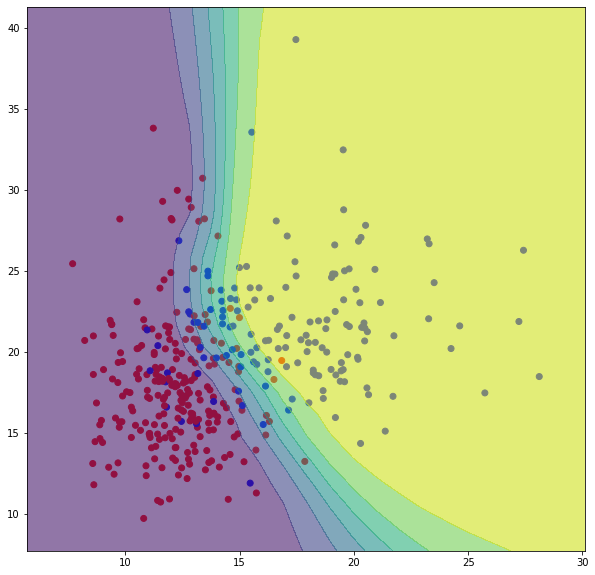

In [7]:
# PLOTTING
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

# Plot the training points
vfunc = np.vectorize(lambda x : np.where(classifier.classes_ == x)[0])
y_train_index = vfunc(y_train)
y_train_index = y_train_index == 0

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train_index, cmap=cm_bright)

classifier.fit(X_train[:, 0:2], y_train_index)

DecisionBoundaryDisplay.from_estimator(
    classifier, X_train[:, 0:2], alpha=0.6, ax=ax, eps=2.0, grid_resolution=25, response_method="predict_proba"
)

In [44]:
import lightgbm as lgb
import xgboost as xgb

In [49]:
# No hyperparams
clf = lgb.LGBMClassifier()
start = time.time()
clf.fit(X_train, y_train)
y_eval2 = clf.predict(X_test, return_winning_probability=True)
print('Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval2))

Prediction time:  0.0983588695526123 Accuracy 0.9468085106382979


In [41]:
# Some hyperparams
clf3 = lgb.LGBMClassifier(max_depth=2, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1)
start = time.time()
clf3.fit(X_train, y_train)
y_eval3 = clf3.predict(X_test, return_winning_probability=True)
print('Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval3))

Prediction time:  0.0895543098449707 Accuracy 0.9627659574468085


In [42]:
# Random forest
clf4 = lgb.LGBMClassifier(max_depth=2, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1, bagging_fraction=0.6, bagging_freq=1)
start = time.time()
clf4.fit(X_train, y_train)
y_eval4 = clf4.predict(X_test, return_winning_probability=True)
print('Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval4))

Prediction time:  0.08361124992370605 Accuracy 0.973404255319149


In [46]:
# No hyperparams
clf5 = xgb.XGBClassifier()
start = time.time()
clf5.fit(X_train, y_train)
y_eval5 = clf5.predict(X_test)
print('Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval5))

Prediction time:  0.12719988822937012 Accuracy 0.9627659574468085


In [53]:
# Some hyperparams
clf6 = xgb.XGBClassifier(max_depth=2, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1)
start = time.time()
clf6.fit(X_train, y_train)
y_eval6 = clf6.predict(X_test)
print('Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval6))

Prediction time:  0.19197893142700195 Accuracy 0.9680851063829787


In [54]:
# Histogram approximation (same as LightGBM)
clf7 = xgb.XGBClassifier(max_depth=2, n_estimators=500, tree_method="hist")
start = time.time()
clf7.fit(X_train, y_train)
y_eval7 = clf7.predict(X_test)
print('Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval7))

Prediction time:  0.2574636936187744 Accuracy 0.9627659574468085


In [58]:
# Random Forest
clf8 = xgb.XGBClassifier(max_depth=2, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1, num_parallel_tree=10)
start = time.time()
clf8.fit(X_train, y_train)
y_eval8 = clf8.predict(X_test)
print('Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval8))


Prediction time:  1.2543296813964844 Accuracy 0.9680851063829787
